In [2]:
import numpy as np
import cvxpy as cp
import qutip as qt
from qutip import wigner, fock, Qobj, displace, destroy, tensor, qeye, coherent, ket2dm, expect, fidelity, fock_dm, ptrace
from qutip.visualization import plot_wigner_fock_distribution, plot_wigner, matrix_histogram, matrix_histogram_complex
from qutip.wigner import wigner
from scipy.special import genlaguerre
from math import sqrt, factorial
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd
from scipy.sparse.linalg import LinearOperator, lsqr
import h5py
from tqdm.auto import tqdm # progress bar
from matplotlib import colors
from tcsim.visualization import*
from tcsim.gates import*
from tcsim.system import*
from tcsim.analyze.dataloader import*

def vectorize(rho):
    """
    Turn hermitian matrix rho into a real vector
    vectorize(rho)[:d] = diag(rho)
    vectorize(rho)[d:d + d*(d-1)/2] = Re[upper_triangle(rho)]
    vectorize(rho)[d + d*(d-1)/2:]  = Im[upper_triangle(rho)]
    """
    d = rho.shape[0]  ## the shape of first column - dimension of matrix, e.g. 3x3 matrix d = 3
    n_offd = d*(d-1)//2 
    ret = np.zeros(d**2) #array of zeros with dimensionality d**2
    i = 0
    for m in range(d):
        ret[m] = rho[m, m].real #mth entry in ret is real part of (m,m) diagonal entry of matrix, capped at d
        for n in range(m+1, d):
            ret[d+i] = rho[m, n].real  #set d+ith entry in ret to real part of (m,n) off diagonal entry of matrix
            ret[d+n_offd+i] = rho[m, n].imag
            i += 1
    return ret


def matricize(rvec):
    """
    Invert the vectorize operation such that matricize(vectorize(rho)) == rho
    """
    d = int(np.sqrt(len(rvec)))
    n_offd = d*(d-1)//2
    ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示
    i = 0
    for m in range(d):
        for n in range(m+1, d):
            real = rvec[d+i]
            imag = rvec[d+n_offd+i]
            val = real + 1j*imag
            ret[m, n] = val
            ret[n, m] = val.conj()
            i += 1
            
def char_ops(hilbert_size, betas):
    ops_list = []

    for beta in tqdm(betas):
        D = displace(100, beta) # need the larger Hilbert space to not get erroneous operators for large beta
        op = D
        op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        ops_list.append(op)

    return ops_list

def reconstruct_char_complex_convex(char, disps, dim):
    # construct vectors
    basis_vectors = []
    for i in range(dim):
        vector = fock(dim, i)
        basis_vectors.append(vector.full())

    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector2, vector1)
            basis_dms.append(dm)
    Pis = char_ops(dim, disps)
    A = np.zeros((len(Pis), dim*dim), dtype=complex)
    
    for index, a in tqdm(np.ndenumerate(A)):
        A[index] = np.trace(Pis[index[0]].full() @ basis_dms[index[1]])
    
    X = cp.Variable((dim,dim), hermitian=True)
    cost = cp.norm(A @ cp.reshape(X, (dim*dim)) - char, 2)
    constraints = [cp.trace(X) == 1, X >> 0]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    reconstructed_rho = Qobj(X.value)
    return reconstructed_rho

def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (X + Y*1j).flatten()

from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from numpy import ma

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2


['003211_panther_sq_vcat_3db_vac.h5', '004651_panther_sq_vcat_3db_vac.h5', '010130_panther_sq_vcat_3db_vac.h5', '011609_panther_sq_vcat_3db_vac.h5', '013049_panther_sq_vcat_3db_vac.h5', '014528_panther_sq_vcat_3db_vac.h5', '020008_panther_sq_vcat_3db_vac.h5', '021447_panther_sq_vcat_3db_vac.h5', '022927_panther_sq_vcat_3db_vac.h5', '024406_panther_sq_vcat_3db_vac.h5']
['025846_panther_sq_vcat_6db_vac.h5', '031325_panther_sq_vcat_6db_vac.h5', '032804_panther_sq_vcat_6db_vac.h5', '034244_panther_sq_vcat_6db_vac.h5', '035723_panther_sq_vcat_6db_vac.h5', '041203_panther_sq_vcat_6db_vac.h5', '042642_panther_sq_vcat_6db_vac.h5', '044121_panther_sq_vcat_6db_vac.h5', '045601_panther_sq_vcat_6db_vac.h5', '051040_panther_sq_vcat_6db_vac.h5']
['194238_panther_sq_vcat_7db_vac.h5', '195000_panther_sq_vcat_7db_vac.h5', '195723_panther_sq_vcat_7db_vac.h5', '200445_panther_sq_vcat_7db_vac.h5', '201207_panther_sq_vcat_7db_vac.h5', '201929_panther_sq_vcat_7db_vac.h5', '202652_panther_sq_vcat_7db_vac.h5'

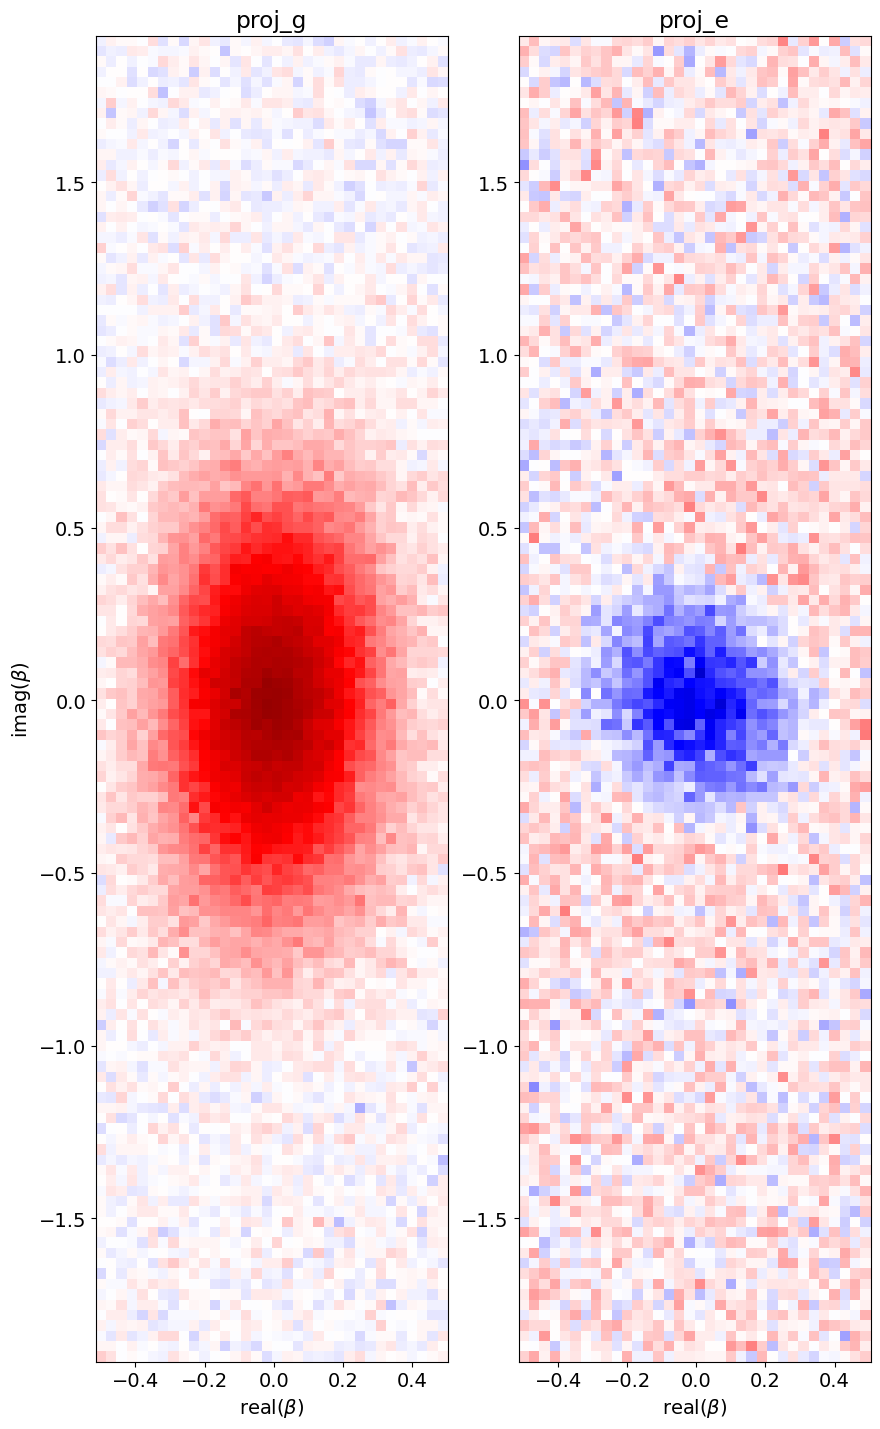

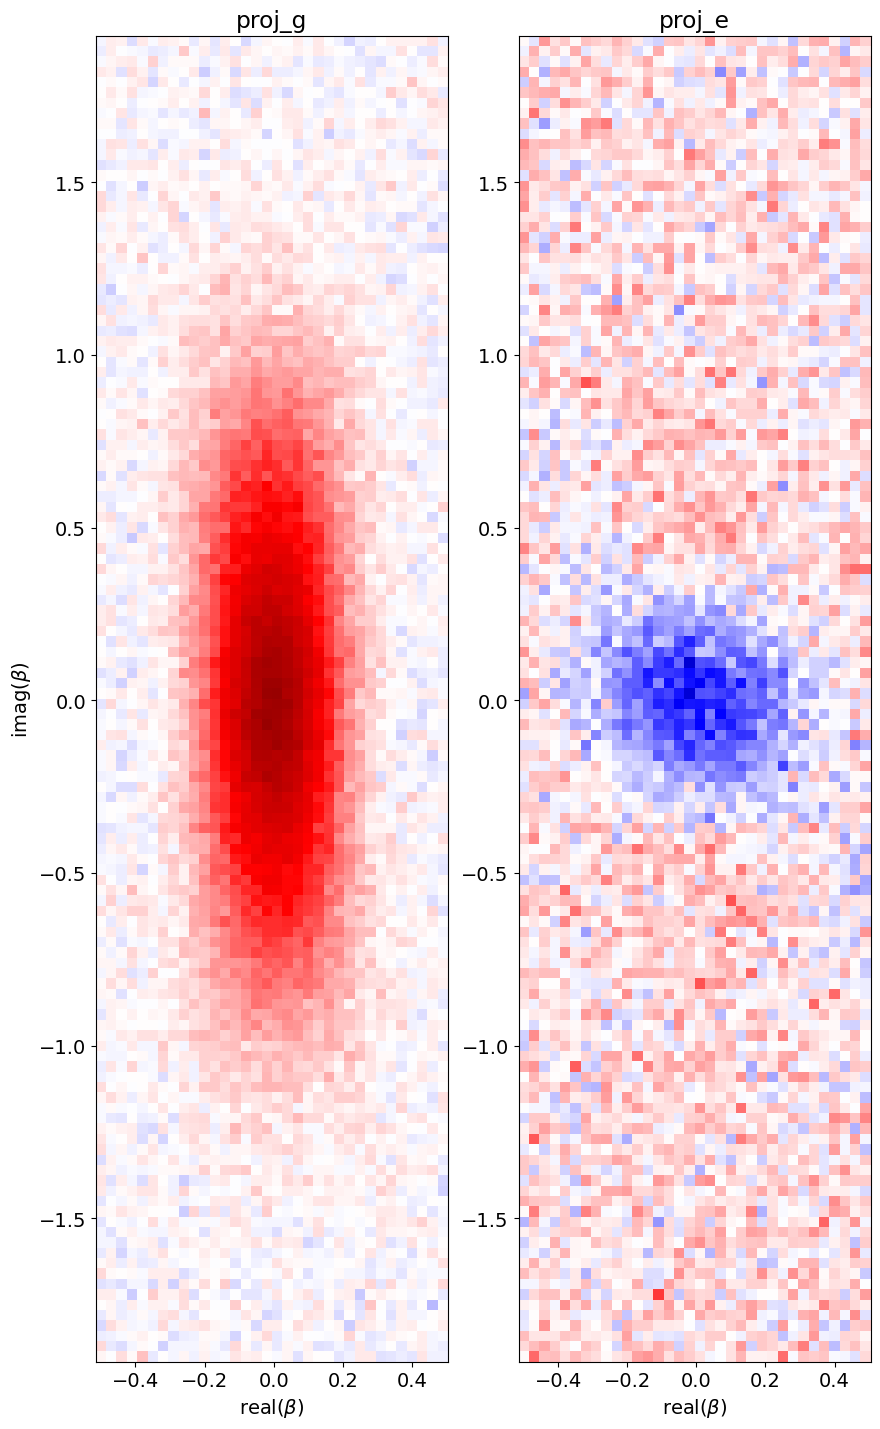

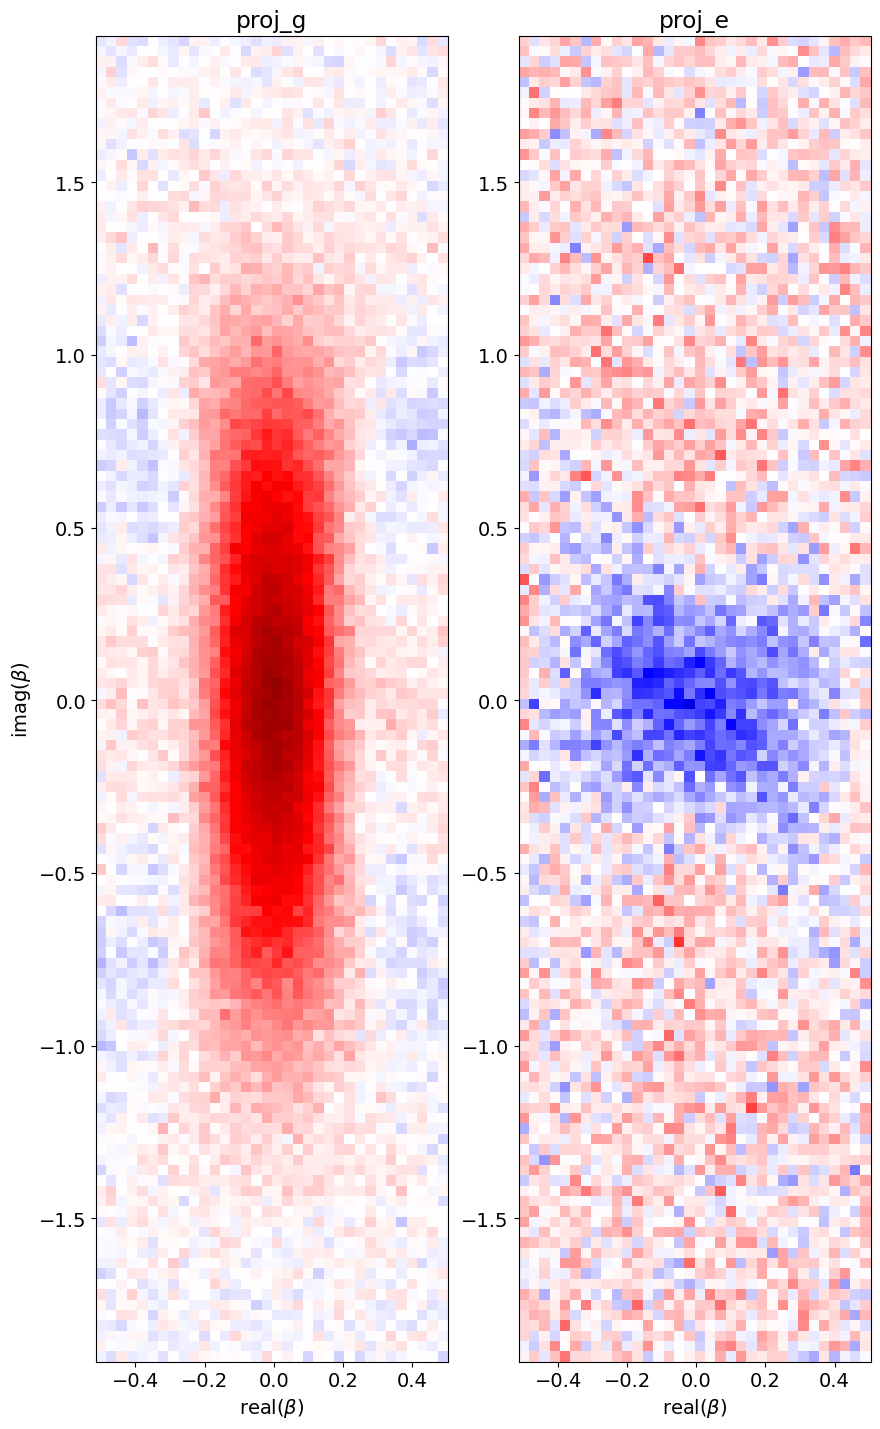

In [8]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os
endswith_array = ['3db_vac.h5', '6db_vac.h5', '7db_vac.h5']
proj_g_array = []
for endswith in endswith_array:
    files1 = []
    files2 = []
    files = []
    d = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
    files = [f for f in os.listdir(d) if f.endswith(endswith)]

    print(files)
    dg = []
    de = []

    #files = files[-5:-1]

    for kk in range(len(files)):
        fname = d + files[kk]
        df = h5py.File(fname, "r")
        data = df["data"]
        data_i = data["I"][:]
        x = data["x"][:, 0][:, 0]
        y = data["y"][0, :][:, 0]
        n_points_x = len(x)  # sweep points x
        n_points_y = len(y)  # sweep points y
        thresh = +0.0002798473592548773 #-3.112326057411744e-05
        ss_data = np.where(data_i < thresh, 1, 0)
        m0 = ss_data[:, 0::3]
        m1 = ss_data[:, 1::3] 
        m2 = ss_data[:, 2::3]
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)

        ## only care about last two measurements
        proj_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1
        proj_e = ma.masked_array(m2, mask=np.logical_not(m1)).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1

        ## condition on the first measurement as well
        double_ps_g = ma.masked_array(m2_g, mask=m1_g).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g)).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1

        dg.append(double_ps_g)
        de.append(double_ps_e)

        
    dg = np.array(dg)
    de = np.array(de)


    proj_g = dg.mean(axis=0)
    proj_e = de.mean(axis=0)
    proj_ge = [proj_g, proj_e]  # m2.mean(axis = 0).reshape(n_points, n_points)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
    f1 = ax1.pcolormesh(y, x, proj_g, cmap="seismic", vmax=1, vmin=-1)
    f2 = ax2.pcolormesh(y, x, proj_e, cmap="seismic", vmax=1, vmin=-1)
    ax1.set_aspect("equal")
    ax1.set_xlabel(r"real($\beta$)")
    ax1.set_ylabel(r"imag($\beta$)")
    ax1.set_title('proj_g')
    ax2.set_aspect("equal")
    ax2.set_xlabel(r"real($\beta$)")
    ax2.set_title('proj_e')
    # fig.colorbar(f2)
    proj_g_array.append(proj_g)

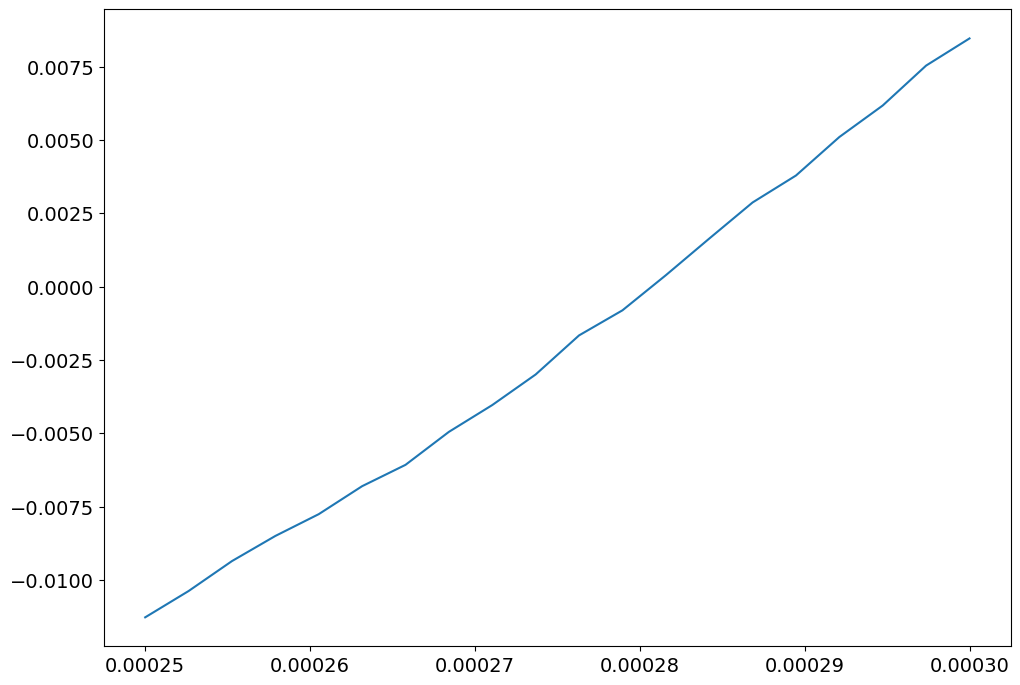

In [5]:
from scipy.optimize import curve_fit


path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"
file_end = '3db_vac.h5'

thresholds = np.linspace(2.5e-4,3e-4, 20)
floor_values = []
for threshold in thresholds:
    x, y, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=threshold, plot=False)
    floor_values.append(data_array[0][0:5,:].mean())
    
plt.plot(thresholds,floor_values)

[ 3.9873948e+02 -1.1158619e-01]
0.0002798473592548773


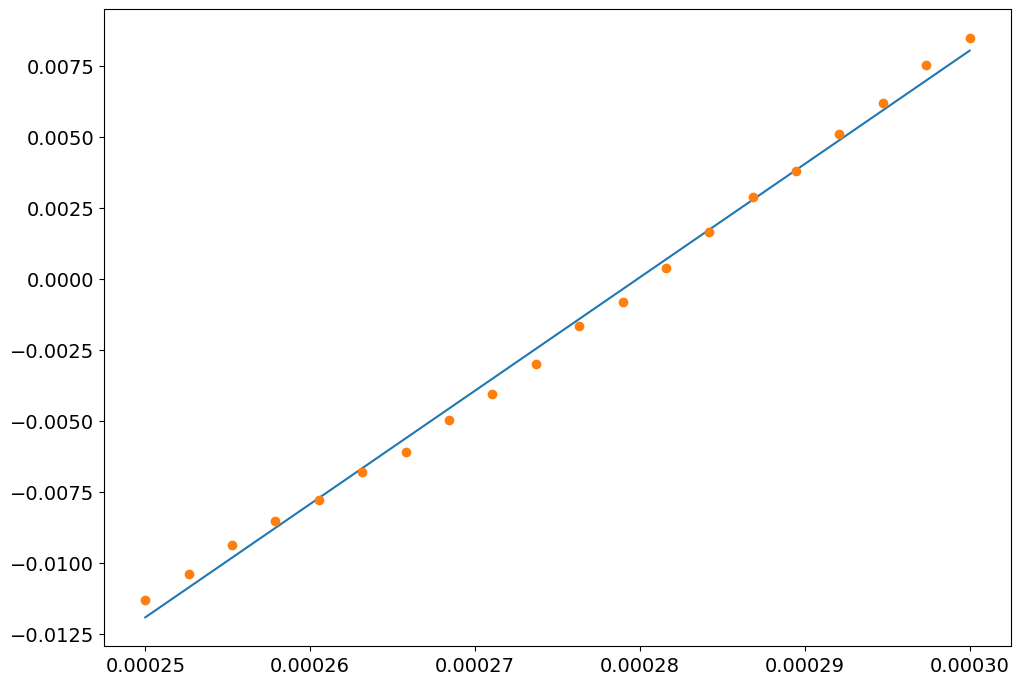

In [7]:
from scipy.optimize import curve_fit

def line(x, m, y):
    return x*m+y
popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])
print(thresh)

In [9]:
# create 2D square array filled with noise
proj_g_square_array = []
for proj_g in proj_g_array:
    noise_pool = proj_g[-1,:]
    noise_square = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            noise_square[i,j] = np.random.choice(noise_pool)
    proj_g_square = noise_square
    for i in range(len(x)):
        proj_g_square[i,int(len(x)/2-len(y)/2):-int((len(x)/2-len(y)/2))] = proj_g[i,:]
    proj_g_square_array.append(proj_g_square)

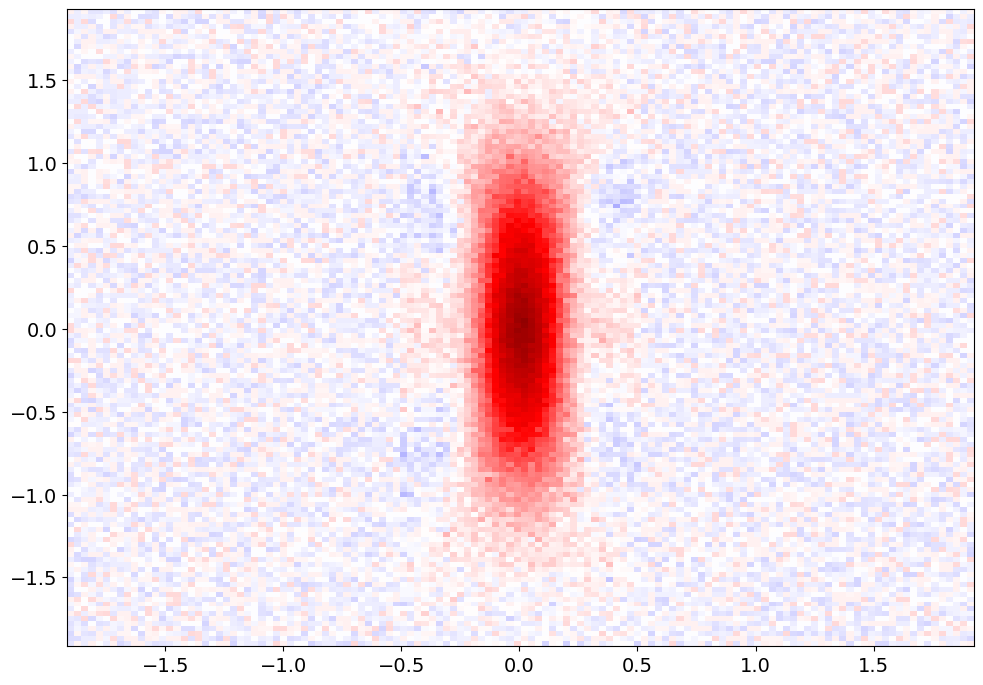

In [10]:
plt.pcolormesh(x, x, proj_g_square_array[2], cmap="seismic", vmax=1, vmin=-1)

In [21]:
proj_with_im = proj_g_square +1j*im
proj_with_im

array([[-0.00433328+0.j, -0.00433328+0.j,  0.03647971+0.j, ...,
         0.0210805 +0.j,  0.00888155+0.j,  0.00616917+0.j],
       [-0.01314802+0.j, -0.0440338 +0.j, -0.00839937+0.j, ...,
        -0.08843061+0.j,  0.00616917+0.j, -0.02252536+0.j],
       [-0.01262106+0.j,  0.00359677+0.j, -0.07623495+0.j, ...,
         0.00191987+0.j,  0.00888155+0.j,  0.03647971+0.j],
       ...,
       [ 0.00359677+0.j, -0.02252536+0.j,  0.01226449+0.j, ...,
        -0.05979227+0.j,  0.00191987+0.j, -0.07623495+0.j],
       [ 0.03647971+0.j, -0.00433328+0.j,  0.00616917+0.j, ...,
        -0.01262106+0.j,  0.01226449+0.j,  0.02344615+0.j],
       [-0.01827455+0.j, -0.02252536+0.j,  0.06934594+0.j, ...,
        -0.02572018+0.j, -0.02572018+0.j,  0.01226449+0.j]])

## Load Experimental Data

In [38]:
N = 20
rho_array = []
rho_tensor_array = []
for proj_g_square in proj_g_square_array:
    im = np.zeros(proj_g_square.shape)
    proj_with_im = proj_g_square/0.884 +1j*im
    re_rho = reconstruct_char_complex_convex(proj_with_im.flatten(),make_disps(np.max(x)*3,len(x)), N)
    rho = Qobj(re_rho)
    rho_array.append(rho)
    rho_tensor_array.append(tensor(qt.fock(2,0)*qt.fock(2,0).dag(),rho))


100%|██████████| 16384/16384 [02:39<00:00, 102.52it/s]
6553600it [01:33, 70318.75it/s]
100%|██████████| 16384/16384 [02:37<00:00, 103.94it/s]
6553600it [01:33, 69826.09it/s]
100%|██████████| 16384/16384 [02:37<00:00, 103.88it/s]
6553600it [01:33, 70055.67it/s]


In [45]:
np.savez("sq_reconstructed_dm", rho_array = rho_array, rho_tensor_array=rho_tensor_array)

In [42]:
N = 20
squeezing_params = [3,6,7]
ideal_squeezed_array = []
for param in squeezing_params:
    sq = qt.squeeze(N,calc_squeez_parameter(param))*fock(N,0)
    ideal_squeezed_array.append(sq)

In [44]:
for i in range(len(rho_array)):
    print("overlap with idea:", expect(rho_array[i],ideal_squeezed_array[i]))
    print("purity:", expect(rho_array[i],rho_array[i]))
    print(rho_array[i].eigenstates()[0][-1])


overlap with idea: 0.8222514055403528
purity: 0.6914150429397914
0.8225689568670851
overlap with idea: 0.7900753283228265
purity: 0.6452465872722749
0.7910552773908133
overlap with idea: 0.78379376218431
purity: 0.6391561980617392
0.787084954367778


In [37]:
print(rho_array[0].eigenstates()[0][-1])
expect(ket2dm(rho_array[0].eigenstates()[1][-1]).unit(), ideal_squeezed_array[i])

Quantum object: dims = [[20], [1]], shape = (20, 1), type = ket
Qobj data =
[[ 9.69957858e-01+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-2.35182309e-01+9.55007530e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 5.98507144e-02-6.03111403e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.04699178e-02+4.21323964e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 1.34430358e-03-2.19870465e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 2.73704215e-03+4.62342535e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.40611325e-03-2.27535226e-05j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 7.57595328e-04-1.94777261e-06j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 2.25354236e-04-7.12485569e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-2.45322516e-03-2.38027851e-03j]
 [ 0.00000000e+00+0.00000000e+00j]]


0.8992939153983981